In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [133]:
n_steps=100
time=np.pi/5
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[0.309 - 0.951*I,                0,                 0,               0,               0,                 0,                0,               0],
[              0,  0.468 - 0.219*I,   0.371 - 0.519*I,               0, -0.53 - 0.213*I,                 0,                0,               0],
[              0,  0.375 - 0.507*I, -0.436 + 0.0748*I,               0, 0.371 - 0.519*I,                 0,                0,               0],
[              0,                0,                 0, 0.468 - 0.219*I,               0,   0.375 - 0.507*I, -0.534 - 0.225*I,               0],
[              0, -0.534 - 0.225*I,   0.375 - 0.507*I,               0, 0.468 - 0.219*I,                 0,                0,               0],
[              0,                0,                 0, 0.371 - 0.519*I,               0, -0.436 + 0.0748*I,  0.375 - 0.507*I,               0],
[              0,                0,                 0, -0.53 - 0.213*I,               0,   0.371 - 0.519*I,  0.468 - 0.219*I,  

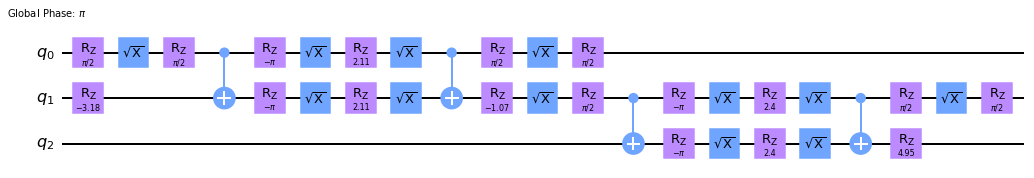

In [134]:
# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

In [135]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[0.9057666294 + 0.4237768435*I,                              0,                             0,                             0,                             0,                              0,                              0,                             0],
[                            0,  0.4681540745 + 0.2190330815*I, 0.7889484898 + 0.3322898616*I,                             0,                             0,                              0,                              0,                             0],
[                            0, -0.3745018365 - 0.5072650329*I, 0.2378719778 + 0.2972213653*I,                             0, -0.6126538413 - 0.286639519*I,                              0,                              0,                             0],
[                            0,                              0,                             0, 0.4602256207 + 0.5750525497*I,                             0, -0.3166559495 - 0.1481523545*I, -0.5336389166 - 0.2247584019*I,            

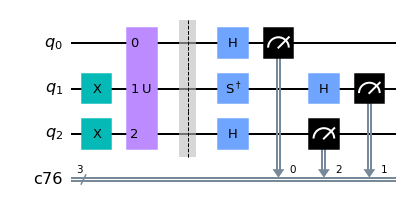

In [136]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [137]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [138]:
cal_circ[0].draw()

░ ┌─┐      
q6241_0: ─░─┤M├──────
          ░ └╥┘┌─┐   
q6241_1: ─░──╫─┤M├───
          ░  ║ └╥┘┌─┐
q6241_2: ─░──╫──╫─┤M├
          ░  ║  ║ └╥┘
  c77: 3/════╩══╩══╩═
             0  1  2

In [139]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [140]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [141]:
calib_circuits_identity[1].draw()

┌────┐┌───┐   ┌─┐
q6245_0: ┤0   ├┤ X ├───┤M├
         │    │└┬─┬┘   └╥┘
q6245_1: ┤1 U ├─┤M├─────╫─
         │    │ └╥┘ ┌─┐ ║ 
q6245_2: ┤2   ├──╫──┤M├─╫─
         └────┘  ║  └╥┘ ║ 
  c81: 3/════════╩═══╩══╩═
                 1   2  0

In [142]:
calib_circuits_itself[1].draw()

┌───┐┌────┐┌─┐      
q6244_0: ┤ X ├┤0   ├┤M├──────
         └───┘│    │└╥┘┌─┐   
q6244_1: ─────┤1 U ├─╫─┤M├───
              │    │ ║ └╥┘┌─┐
q6244_2: ─────┤2   ├─╫──╫─┤M├
              └────┘ ║  ║ └╥┘
  c80: 3/════════════╩══╩══╩═
                     0  1  2

In [143]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

In [144]:
qiskit_raw_cal = deepcopy(job_cal_qiskit.result().get_counts())

# Mitigation:

    - building the calibration matrices

In [145]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [148]:
not_migigated_qiskit = occurrences_to_matrix(qiskit_raw_cal)
Matrix(not_migigated_qiskit).n(2, chop=True)

Matrix([
[  0.94,   0.049,   0.033, 0.0017, 0.032,  0.0018, 0.00075,       0],
[ 0.019,    0.91, 0.00069,  0.031,     0,   0.032,       0, 0.00091],
[0.0097, 0.00056,    0.92,  0.047,     0,       0,   0.032,  0.0013],
[     0,   0.011,   0.016,   0.89,     0,       0, 0.00072,   0.028],
[ 0.029,  0.0016, 0.00094,      0,  0.94,   0.049,   0.034,  0.0018],
[0.0005,   0.027,       0,  0.001, 0.019,    0.91, 0.00059,   0.032],
[0.0005,       0,   0.026, 0.0017, 0.011, 0.00059,    0.91,    0.05],
[     0,       0, 0.00066,  0.026,     0,    0.01,   0.019,    0.89]])

In [149]:
calib = np.linalg.multi_dot([migigated_qiskit, np.linalg.inv(not_migigated_qiskit)])
Matrix(calib).n(2, chop=True)

Matrix([
[    1.1, -0.057,  -0.038,  0.002,  -0.036,  0.0019,  0.0018,      0],
[ -0.023,    1.1, 0.00066, -0.038, 0.00099,  -0.039,       0, 0.0015],
[ -0.011, 0.0006,     1.1, -0.057,       0,       0,  -0.038, 0.0024],
[      0, -0.013,   -0.02,    1.1,       0,       0, 0.00054, -0.036],
[ -0.033, 0.0016,  0.0012,      0,     1.1,  -0.058,   -0.04, 0.0021],
[0.00079, -0.033,       0,  0.001,  -0.022,     1.1, 0.00091,  -0.04],
[      0,      0,  -0.031, 0.0014,  -0.013, 0.00067,     1.1, -0.062],
[      0,      0,       0, -0.034,       0,  -0.013,  -0.023,    1.1]])

In [150]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [151]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [152]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q7379_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
          ░ └─┬─┬─┘ └───┘      └╥┘   
q7379_1: ─░───┤M├───────────────╫────
          ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q7379_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
          ░    ║   └─────┘└───┘ ║ └╥┘
  c94: 3/══════╩════════════════╩══╩═
               1                0  2

In [153]:
C_matrices_itself = []
C_matrices_identity = []

U_ideal_inv = np.linalg.inv(U_ideal)
U_ideal_inv_abs = np.abs(U_ideal_inv)**2

U_ideal_abs = np.abs(U_ideal)**2
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)

C_itself = np.dot(U_tilde_itself, U_ideal_abs_inv)
C_identity = U_tilde_identity

for base in qcs_basis:
    
    '''
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.dot(base_matrix, C_identity).dot(base_matrix_H)

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))
    '''

    base.remove_final_measurements()

    base_matrix = matrix_from_cirquit(base, type="numpy")
    base_matrix_H = np.linalg.inv(base_matrix)

    #C_aus_itself = np.linalg.multi_dot([base_matrix, C_itself,  base_matrix_H])
    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [154]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [155]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [156]:
raw_res.get_counts(-1)

{'100': 1089,
 '110': 7528,
 '001': 810,
 '000': 82,
 '010': 957,
 '111': 1079,
 '011': 9349,
 '101': 11106}

In [157]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit


In [158]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    
    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [159]:
raw_res.get_counts(-1)

{'100': 1089,
 '110': 7528,
 '001': 810,
 '000': 82,
 '010': 957,
 '111': 1079,
 '011': 9349,
 '101': 11106}

In [160]:
itself_res.get_counts(-1)

{'000': 8.343033565383577e-12,
 '001': 17.521535461858964,
 '010': 89.87182537261744,
 '011': 10724.184192108683,
 '100': 9.059957969997508e-11,
 '101': 12614.112490758407,
 '110': 8485.93869403595,
 '111': 68.37126226238142}

In [161]:
identity_res.get_counts(-1)

{'000': 4.065310213221159e-10,
 '001': 2.002470838196068e-09,
 '010': 18.463550516431553,
 '011': 10784.223954105235,
 '100': 8.235135269270552e-12,
 '101': 12596.510879707695,
 '110': 8361.849230390217,
 '111': 238.95238527829503}

In [162]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.2361973 , 0.2558709 , 0.25766778, 0.26643912])